In [42]:
data_dir = '/datasets/COCO-2015/train2014'
annotation_file = 'annotations/captions_train2014.json'
val_dir = '/datasets/COCO-2015/val2014'
val_annotation_file = 'annotations/captions_val2014.json'

In [43]:
#load data
import nbimporter
import data_loader as data_loader
import pickle
from vocabbuild import Vocabulary
import torchvision.transforms as transforms
import torch.utils.data as td

with open("vocab.pkl", 'rb') as fi:
    vocabulary = pickle.load(fi)

image_size = (229,229)
transform = transforms.Compose([ 
        # Try resize
        #transforms.RandomCrop(crop_size), 
        transforms.Resize(image_size),
        transforms.ToTensor(), 
        # Using Imagenet std and mean
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])   

coco_train = data_loader.COCODataset(root = data_dir, annFile = annotation_file, 
                                     vocabulary=vocabulary, transform = transform)
train_loader = td.DataLoader(coco_train, batch_size = 1, shuffle = True,
                                         pin_memory = True, collate_fn = data_loader.coco_batch)

coco_val = data_loader.COCODataset(root = val_dir, annFile = val_annotation_file, 
                                     vocabulary=vocabulary, transform = transform)
val_loader = td.DataLoader(coco_val, batch_size = 1, shuffle = False,
                                         pin_memory = True, collate_fn = data_loader.coco_batch)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [44]:
#check train_loader
# for i, (images, captions, lengths) in enumerate(train_loader):
#     if (i > 4):
#         break
#     data_loader.myimshow(images[0])
#     cap_string = ""
#     for j in list(captions.data.numpy()[0]):
#         cap_string += vocabulary.idx2word[j] + " "        
#     print(cap_string)

In [51]:
#plot functions
import matplotlib.pyplot as plt
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
    label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
    label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
    label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
    label="evaluation accuracy")
    axes[1].set_xlabel("epochs")
    axes[0].set_xlabel("epochs")
    axes[1].set_ylabel("accuracy")
    axes[0].set_ylabel("loss")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    fig.canvas.draw()

In [52]:
# Device configuration
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [53]:
import weight_initialization
weight_matrix = weight_initialization.get_weight_matrix()

In [54]:
import nntools as nt
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.classification_loss = nn.CrossEntropyLoss()
    def criterion(self, y, d):
        # MSE loss implementation
        return self.classification_loss(y, d)

In [55]:
#define decoder network
from torch import nn

def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class LSTM_custom(NNClassifier):
    def __init__(self, weights_matrix, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(LSTM_custom, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
    
    def forward(self, features, captions, lengths):
        embeddings = self.embedding(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

In [56]:
# Build the models
import models_custom
encoder = models_custom.CNN(out_classes = 300).to(device)
decoder = LSTM_custom(weights_matrix = weight_matrix, hidden_size = 512, 
                             vocab_size = weight_matrix.shape[0], num_layers = 1).to(device)

In [57]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = (100 * self.running_accuracy)/self.number_update
        return {'loss': loss, 'accuracy': accuracy}

In [59]:
lr = 1e-4
adam = torch.optim.Adam(decoder.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(decoder, train_loader, val_loader, adam, stats_manager,
output_dir="captioning", perform_validation_during_training=True)

TypeError: run() got an unexpected keyword argument 'encoder_net'

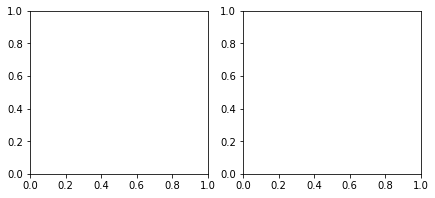

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(encoder_net=encoder, num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))